In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Import our custom classifier
from pipeline.classification.HAN_classifier import HierarchicalAttentionNetwork

In [3]:
# Define model directory path
MODEL_DIR = Path("../models")  # Relative to notebook location
TRAIN_PATH = Path("../../data/train.csv")
TEST_PATH = Path("../../data/test.csv")
VALIDATION_PATH = Path("../../data/validation.csv")
UNSEEN_PATH = Path("../../data/unseen.csv")

In [15]:
class_names = {
    1: 'Receipt', 
    2: 'Email',
    3: 'Invoice',
    4: 'Other',
    5: 'Contract'
}

Class distribution:
label
5    180
4    180
3    180
2    180
1    180
Name: count, dtype: int64


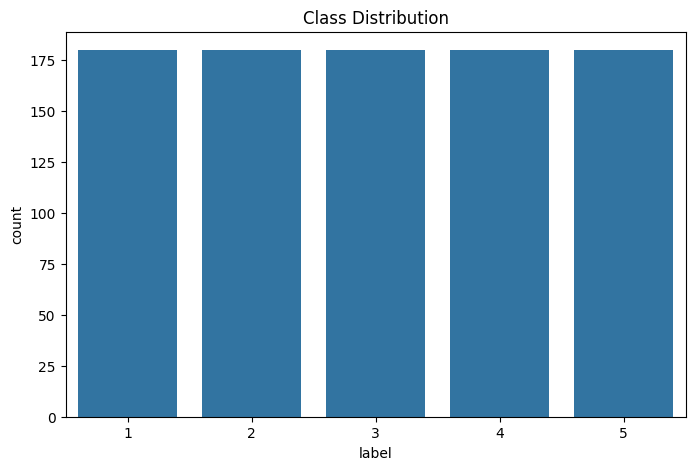

In [16]:
# Load data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# Check class distribution
print("Class distribution:")
print(train_df['label'].value_counts())

# Visualize
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution')
plt.show()


Text length statistics:
count       900.000000
mean       5928.721111
std       18334.730056
min           0.000000
25%         468.500000
50%         849.000000
75%        5946.000000
max      359241.000000
Name: text_length, dtype: float64


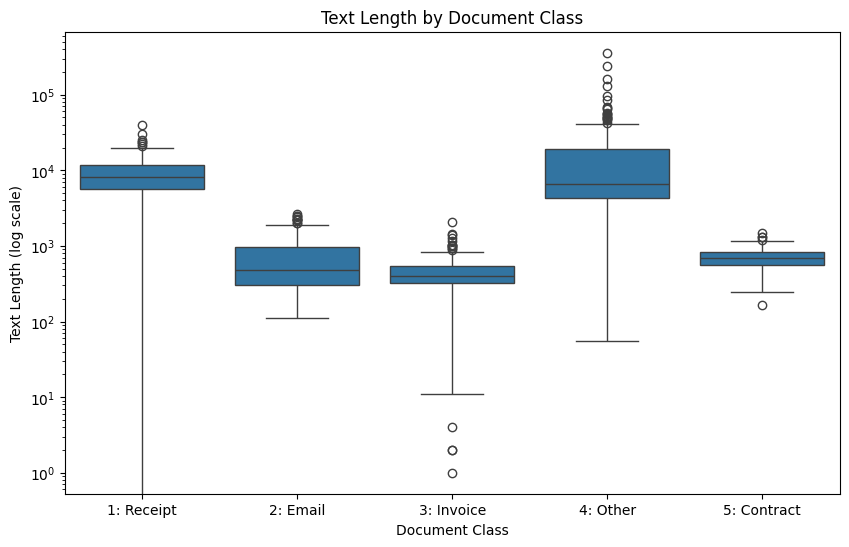

In [18]:
# Check text length statistics
train_df['text_length'] = train_df['text'].fillna("").apply(len)
print("\nText length statistics:")
print(train_df['text_length'].describe())

# Plot text length distribution by class
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=train_df)
plt.title('Text Length by Document Class')
plt.yscale('log')
plt.xlabel('Document Class')
plt.ylabel('Text Length (log scale)')
plt.xticks(range(len(class_names)), [f"{k}: {v}" for k, v in class_names.items()])
plt.show()

In [5]:
print("\nClass distribution in training data:")
class_dist = train_df['label'].value_counts().sort_index()
print(class_dist)


Class distribution in training data:
label
1    180
2    180
3    180
4    180
5    180
Name: count, dtype: int64


In [6]:
print("\nMissing values in train data:")
print(train_df.isnull().sum())


Missing values in train data:
id            0
filename      0
text         13
label         0
timestamp     0
dtype: int64


In [7]:
han_classifier = HierarchicalAttentionNetwork(
    max_features=20000,        # Vocabulary size
    max_sentences=15,          # Max sentences per document
    max_sentence_length=50,    # Max words per sentence
    embedding_dim=100,         # Word embedding dimension
    gru_units=100,             # GRU units in BiGRU layers
    dropout_rate=0.3,          # Dropout for regularization
    model_dir=MODEL_DIR        # Where to save model
)

In [8]:
print("\nTraining the HAN classifier...")
history = han_classifier.train(
    train_path=TRAIN_PATH,
    validation_path=VALIDATION_PATH,  # Use separate validation file
    batch_size=16,                    # Adjust based on your GPU memory
    epochs=20                         # Max epochs (early stopping will likely trigger)
)


Training the HAN classifier...
Training on 900 documents

Class distribution:
label
1    180
2    180
3    180
4    180
5    180
Name: count, dtype: int64

Preprocessing documents...
Document sequence shape: (900, 15, 50)

Building HAN model...


/opt/homebrew/Caskroom/miniconda/base/envs/stats-project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sentence_input (InputLayer)     │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 200)        │     2,121,450 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 15, 200)        │       181,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sentence_attention              │ (None, 200)            │           215 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,303,870 (8.79 MB)

 Trainable params: 2,303,870 (8.79 MB)

 Non-trainable params: 0 (0.00 B)

None
Using separate validation data from ../../data/validation.csv
Validation data shape: (300, 15, 50)

Training model...
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 433ms/step - accuracy: 0.2670 - loss: 1.5105 - val_accuracy: 0.4000 - val_loss: 1.2215
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.4702 - loss: 1.1856 - val_accuracy: 0.6400 - val_loss: 0.9634
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.6276 - loss: 0.9235 - val_accuracy: 0.8800 - val_loss: 0.3730
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - accuracy: 0.9329 - loss: 0.2769 - val_accuracy: 0.9233 - val_loss: 0.2506
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - accuracy: 0.9569 - loss: 0.1119 - val_accuracy: 0.9267 - val_loss: 0.2123
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 437ms/step - accuracy: 0.9793 - loss: 0.0744 - val_accuracy: 0.9367 - val_loss: 0.1490
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 431ms/step - accuracy: 0.9889 - loss: 0.0434 - val_accuracy: 

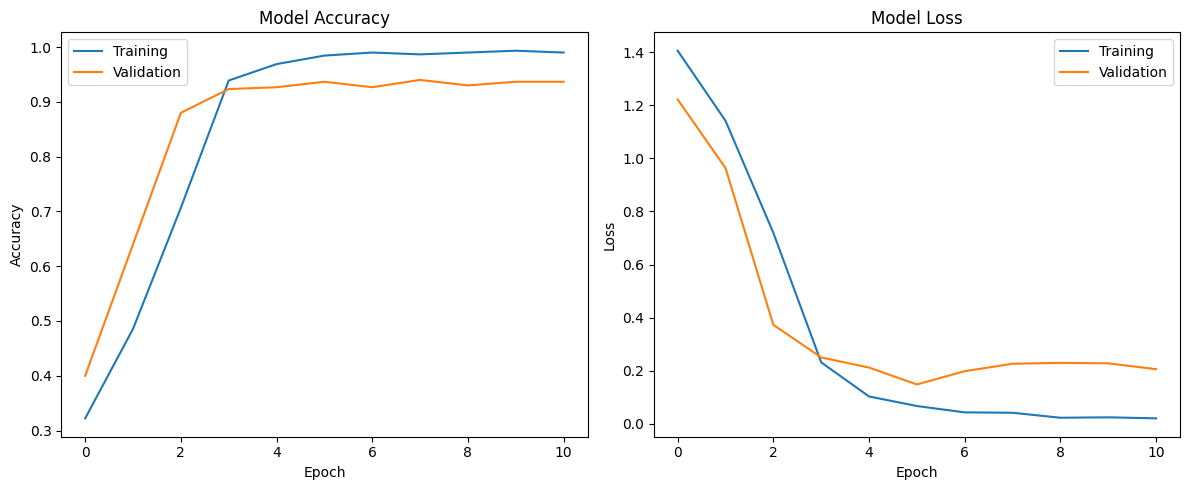

In [9]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
print("\nEvaluating on test data...")
test_results = han_classifier.evaluate(TEST_PATH)


Evaluating on test data...
Evaluating on 300 documents
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9492 - loss: 0.1635

Test loss: 0.1607
Test accuracy: 0.9567
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.95      0.97        60
           2       0.92      0.98      0.95        60
           3       0.90      0.93      0.92        60
           4       0.98      0.95      0.97        60
           5       0.98      0.97      0.97        60

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



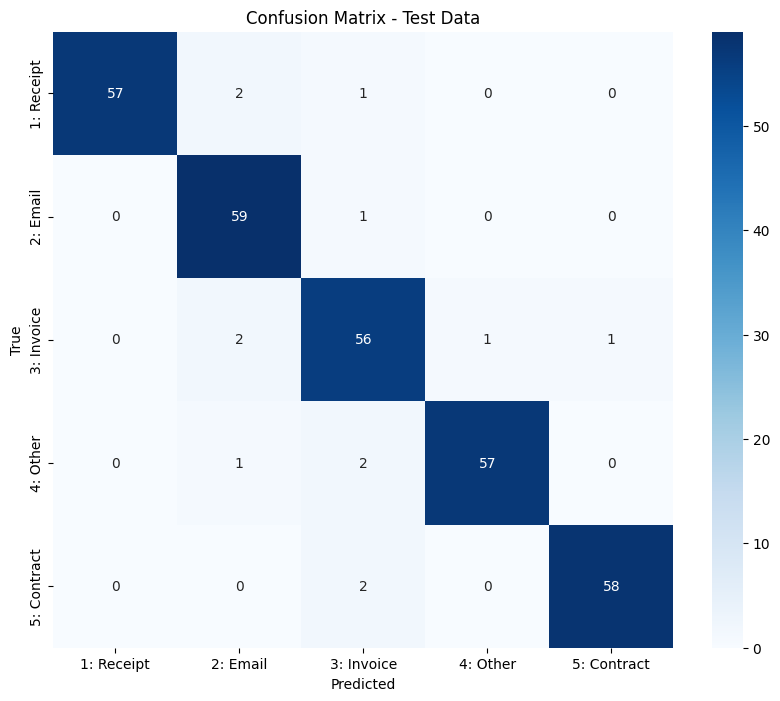

In [13]:
predictions = test_results['predictions']
cm = confusion_matrix(test_df['label'], predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"{k}: {v}" for k, v in class_names.items()], 
            yticklabels=[f"{k}: {v}" for k, v in class_names.items()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [20]:
print("\nModel saved at:", MODEL_DIR)


Model saved at: ../models


In [22]:
loaded_classifier = HierarchicalAttentionNetwork(model_dir=MODEL_DIR)
loaded_classifier.load_model()

/opt/homebrew/Caskroom/miniconda/base/envs/stats-project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sentence_input (InputLayer)     │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 200)        │     2,121,450 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 15, 200)        │       181,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sentence_attention              │ (None, 200)            │           215 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,303,870 (8.79 MB)

 Trainable params: 2,303,870 (8.79 MB)

 Non-trainable params: 0 (0.00 B)

None
Model loaded from ../models/han_model_final.weights.h5


/opt/homebrew/Caskroom/miniconda/base/envs/stats-project/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
